In [1]:
import os
os.chdir('..')

import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

d:\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import backend as K

# Подготовка, исследование и тесты.

Выбрал из 3х предложенных задач human_segmentation так как сразу возникла идея как ее решить (на ум пришла архитектура энкодер-декодер). К тому же она показалось мне самой наглядной.

Базовая идея была сделать сверточный автокодировщик (источник идеи книга ["Глубокое обучение. Погружение в мир нейронных сетей"](https://habr.com/ru/company/piter/blog/346358/) которую я потихоньку изучаю). Был соблаз сразу реализовать и проверить возможности данного подхода, но я последовал вашему свету и пошел изучать литературу по моделям сегментации. 

Прочитав предложенную вами [статью](https://arxiv.org/pdf/1505.04597.pdf), увидел что мой вариант со сверточным автокодировщиком был близок к оптимальной (более подходящей для сегментации) архитектуре, добавились только связи `copy and crop`. некоторые описанные подходы аугментации данных в статье показались мне не подходящими для моделей human_segmentation (например elastic deformations), все таки человеческий силуэт имеет четкую структуру в отличие от клеток тканей на фотографиях с микроскопа.

Дальше я решил поискать примеры реализации модели для сегментации силуэтов в интернете (с нуля у меня не хватает опыта писать, пока что мне проще адаптировать примеры под свою задачу) и наткнулся на этот [туториал](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) в котором подробно описывается решение задачи идентичной вашей. Та же архитектура что и в [статье](https://arxiv.org/pdf/1505.04597.pdf) (только добавлены операции батч нормализации между слоями)! Так же были приведены примера аугментации данных. Потому я решил переработать предложенное решение под свою задачу.



## Аугментация

Я вынес функции аугментации в отдельный модуль `image_augmentation`, разобрался как с ними работать и проверил их в отдельном ноутбуке `ImageExperiments`. 

Так же добавил свою функцию для поворота изображения на случайный угол в заданном диапазоне. Мне кажется этот вариант самым логичным в данной задаче, так как люди часто наклоняют голову например или фотографирую не совсем ровно держа телефон (фотоаппарат). При повороте качество изображения снижается, но я счел это допустимым. Так же диапазон угла поворота не очень большой, так как я не хочу перевернуть изображение кверх ногами - даже люди хуже воспринимают лица других людей, если они перевернуты. Я к тому, что решил не учить этому нейросеть.

Еще я подумывал сделать функцию для комбинации нескольких фотографий в одну, но понял что на всех примерах выделен один человек и одна полносвязная область, потому отбросил эту идею.

Итого методы аугментации которые я применяю:
- Изменение тона изображения (на случайную величину)
- Сдвиг (равномерное распределение в отдельных для высоти и ширины диапазонах)
- Отражение по горизонтали (с вероятностью 0.5)
- Поворот (равномерное распределение углов в заданном диапазоне

Это позволяет заметно расширить нашу небогатую выборку обучающих примеров.

## Подготовка данных

Я постарался вынести основной функционал для подготовки данных в модуль `dataset_utils`, но очень сомневаюсь в правильности компоновки. Тут у меня возникает много вопросов по тому, стоит ли функцию выносить в модуль или же оставить ее в ноутбуке. С аугментацией все ясно - это набор универсальных функций, которые можно использовать в разных проектах. А вот загрузка картинок сильно привязана к структуре текущего датасета. Тут у меня нет опыта, надеюсь смогу обсудить это с вами на стажировке. А так, это модуль скорее плохо организован, чем хорошо.

Все картинки загружаются в `tf.data.Dataset`, объект который предоставляет возможность паралельной предобработки, аугментации данных, генерации батчей и другое.

## Метрики

В ваш модуль `metrics` я добавил функции из [примера](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) так как они заточены на работу с `tensorflow`.

Так же в примере предлагают использовать в качестве целевой функции (возможно неправильная терминология, опыта нет) `binary cross entropy` + `dice loss`, но валидировать модель по `dice loss`. Я пробовал в качестве целевой функции использовать просто 'dice loss', но тогда модель начинает добавлять "пустоты" в маски, компенсируя выходы за границы эталонной маски (как мне кажется). Ниже в ноутбуке есть примеры.

Плюс предложенная метрика хорошо показала себя в [соревновании](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199).

## Модель

Функционал создания моделей я вынес в модуль `segmentation_model`.

Модель строится с помощью функционального API Keras (Вот тут у меня тоже не понимания как правильно описывать модели в модулях, так как опыта нет). Я описал 2 модели, одна это упрощенный вариант из [примера](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)(упрощенный с целью ускорения обучения на домашнем ПК), вторая модель аналогична первой, но без батч нормализации (Хотел наглядно показать ее пользу).

Тесты я проводил на 10 эпохах, финальный вариант обучил на 100. Хотелось бы больше внимания тестам уделить, но время поджимало. Все модели сохранялись в папку `saved_models`.

Модели и тесты:
- Модель без батч нормализации, оптимизатор `adam` с параметрами по умолчанию (name - model_test_0)
- Модель с батч нормализацией, оптимизатор `adam` с параметрами по умолчанию (name - model_test)
- Модель с батч нормализацией, оптимизатор `adam`, параметр `lr` (скорость обучения) изменен с 0.001 на 0.0001 (name - model_test_1)
- Модель с батч нормализацией, оптимизатор `adam`, добавлен параметр `decay=0.001` (убывание скорости обучения)(name - model_test_2)
- Модель с батч нормализацией, оптимизатор `adam`, добавлен параметр `decay=0.001`, целевая функция `dice_loss`(name - model_test_2dice)
- Финальная модель с батч нормализацией, оптимизатор `adam`, добавлен параметр `decay=0.001`, целевая функция `bce_dice_loss`, 100 эпох обучения (name - model_final)

## Результаты

Dice loss на валидационной выборке составил `0.05638`. Считаю результат приемлемым, хотя можно еще улучшить как мне кажется (усложнить модель добавив промежуточных прихнаков или уровней, подобрать скорость обучения, попробовать поменять вес dice loss в bce_dice_loss).

В самом конце ноутбука на основе предсказания финальной модели создаю файлы для проверки (картинки и html страницу).
Пришлось немного переписать функцию создания html страницы, так как там используется модуль `glob` который рассчитан на работу с Unix, я же работаю из под Windows 10 (опыт работы с Linux есть, просто на домашнем компьютере он не стоит, хотя иногда пользуюсь встроенной в WIN10 версией Ubuntu, которая ставится из Microsoft Store). Метод адаптации функции к Windows конечно носит формат 'затычки' для получения результата. По хорошему, нужно было переписать код без использования `glob`. Это я к тому, что понимаю что такие хаки это плохо)

#### Генерация valid.csv (которую я проморгал)

В самом конце используя итоговую модель, предсказываю маски для валидационных фотографий и записываю в файл `data/pred_valid.csv`.

In [6]:
x_path = 'data/data/train'
y_path = 'data/data/train_mask'
x_train_filenames, y_train_filenames = dataset_utils.get_images_filenames(x_path, y_path)

In [7]:
x_path = 'data/data/valid'
y_path = 'data/data/valid_mask'
x_valid_filenames, y_valid_filenames = dataset_utils.get_images_filenames(x_path, y_path)

In [8]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_valid_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 1315
Number of validation examples: 145


In [9]:
import matplotlib.image as mpimg

In [10]:
img_shape = (320, 240, 3)
batch_size = 16
epochs = 10

In [11]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'shift_range_pxls': (img_shape[0]*0.1, img_shape[1]*0.1),
    'angle_rad_range': 0.1,
}
tr_preprocessing_fn = functools.partial(image_augmentation.augment, **tr_cfg)

In [12]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(image_augmentation.augment, **val_cfg)

In [ ]:
train_ds = dataset_utils.get_baseline_dataset(x_train_filenames,
                                              y_train_filenames,
                                              preproc_fn=tr_preprocessing_fn,
                                              batch_size=batch_size)
val_ds = dataset_utils.get_baseline_dataset(x_valid_filenames,
                                            y_valid_filenames, 
                                            preproc_fn=val_preprocessing_fn,
                                            batch_size=batch_size)

In [20]:
model = segmentation_model.get_model_test_0(img_shape)
model.compile(optimizer='adam', loss=metrics.bce_dice_loss, metrics=[metrics.dice_loss])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 240, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 240, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 240, 8)  584         activation[0][0]                 
______________________________________________________________________________________________

### Модель без батч нормализации, оптимизатор `adam` с параметрами по умолчанию (name - model_test_0)

In [12]:
save_model_path = 'saved_models/model_test_0'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [13]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/10
82/83 [============================>.] - ETA: 0s - loss: 0.9250 - dice_loss: 0.3592
Epoch 00001: val_dice_loss improved from inf to 0.28646, saving model to saved_models/model_test_0
83/83 [==============================] - 31s 377ms/step - loss: 0.9218 - dice_loss: 0.3573 - val_loss: 1.8090 - val_dice_loss: 0.2865
Epoch 2/10
82/83 [============================>.] - ETA: 0s - loss: 0.6323 - dice_loss: 0.2107
Epoch 00002: val_dice_loss did not improve from 0.28646
83/83 [==============================] - 19s 224ms/step - loss: 0.6319 - dice_loss: 0.2103 - val_loss: 1.3499 - val_dice_loss: 0.2999
Epoch 3/10
82/83 [============================>.] - ETA: 0s - loss: 0.5702 - dice_loss: 0.1893
Epoch 00003: val_dice_loss did not improve from 0.28646
83/83 [==============================] - 19s 225ms/step - loss: 0.5699 - dice_loss: 0.1892 - val_loss: 1.2224 - val_dice_loss: 0.2945
Epoch 4/10
82/83 [============================>.] - ETA: 0s - loss: 0.5204 - dice_loss: 0.1717
Epoch 0

In [24]:
def plot_fit_history(history):
    dice = history.history['dice_loss']
    val_dice = history.history['val_dice_loss']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, dice, label='Training Dice Loss')
    plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Dice Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [17]:
def draw_examples(model, val_ds):
    data_aug_iter = val_ds.make_one_shot_iterator()
    next_element = data_aug_iter.get_next()

    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 20))
    for i in range(5):
      batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
      img = batch_of_imgs[0]
      predicted_label = model.predict(batch_of_imgs)[0]

      plt.subplot(5, 3, 3 * i + 1)
      plt.imshow(img)
      plt.title("Input image")

      plt.subplot(5, 3, 3 * i + 2)
      plt.imshow(label[0, :, :, 0])
      plt.title("Actual Mask")
      plt.subplot(5, 3, 3 * i + 3)
      plt.imshow(predicted_label[:, :, 0])
      plt.title("Predicted Mask")
    plt.suptitle("Examples of Input Image, Label, and Prediction")
    plt.show()

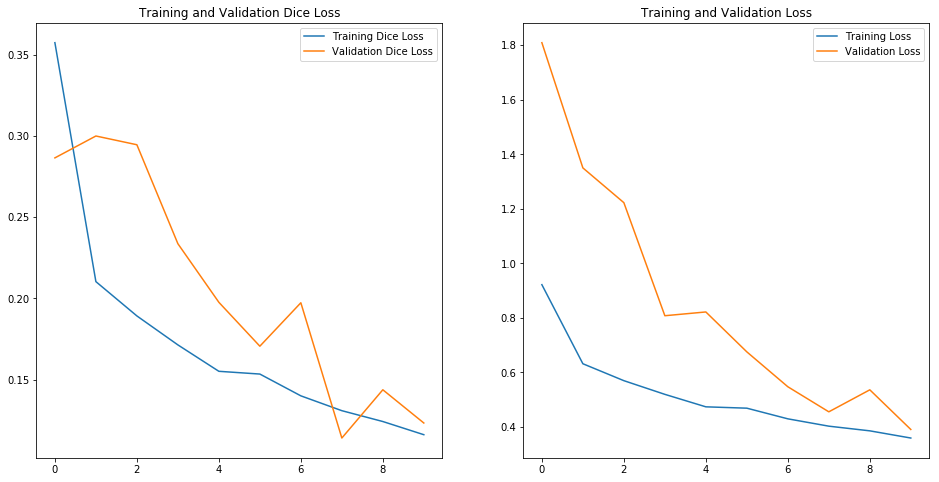

In [15]:
plot_fit_history(history)

### Модель с батч нормализацией, оптимизатор `adam` с параметрами по умолчанию (name - model_test)

In [16]:
model = segmentation_model.get_model(img_shape)
model.compile(optimizer='adam', loss=metrics.bce_dice_loss, metrics=[metrics.dice_loss])
save_model_path = 'saved_models/model_test'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [17]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/10
82/83 [============================>.] - ETA: 0s - loss: 0.7788 - dice_loss: 0.2940
Epoch 00001: val_dice_loss improved from inf to 0.41770, saving model to saved_models/model_test
83/83 [==============================] - 39s 475ms/step - loss: 0.7754 - dice_loss: 0.2927 - val_loss: 1.0274 - val_dice_loss: 0.4177
Epoch 2/10
82/83 [============================>.] - ETA: 0s - loss: 0.5352 - dice_loss: 0.1922
Epoch 00002: val_dice_loss improved from 0.41770 to 0.40783, saving model to saved_models/model_test
83/83 [==============================] - 24s 291ms/step - loss: 0.5357 - dice_loss: 0.1922 - val_loss: 1.1120 - val_dice_loss: 0.4078
Epoch 3/10
82/83 [============================>.] - ETA: 0s - loss: 0.4410 - dice_loss: 0.1536
Epoch 00003: val_dice_loss improved from 0.40783 to 0.16293, saving model to saved_models/model_test
83/83 [==============================] - 24s 294ms/step - loss: 0.4407 - dice_loss: 0.1534 - val_loss: 0.6944 - val_dice_loss: 0.1629
Epoch 4/10
82/

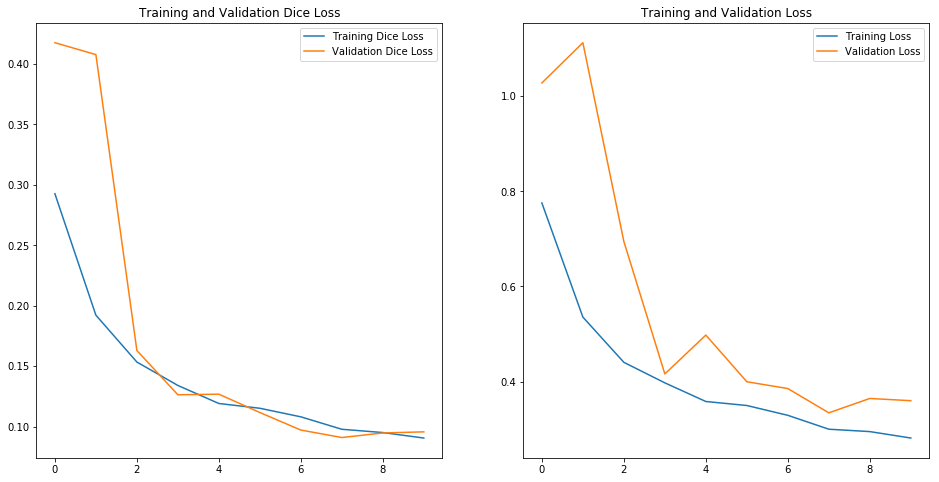

In [18]:
plot_fit_history(history)

### Модель с батч нормализацией, оптимизатор `adam`, параметр `lr` (скорость обучения) изменен с 0.001 на 0.0001 (name - model_test_1)

In [26]:
model = segmentation_model.get_model(img_shape)
optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss=metrics.bce_dice_loss, metrics=[metrics.dice_loss])
save_model_path = 'saved_models/model_test_1'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [27]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/10
82/83 [============================>.] - ETA: 0s - loss: 1.0711 - dice_loss: 0.3780
Epoch 00001: val_dice_loss improved from inf to 0.47779, saving model to saved_models/model_test_1
83/83 [==============================] - 51s 615ms/step - loss: 1.0694 - dice_loss: 0.3775 - val_loss: 1.1899 - val_dice_loss: 0.4778
Epoch 2/10
82/83 [============================>.] - ETA: 0s - loss: 0.9347 - dice_loss: 0.3373
Epoch 00002: val_dice_loss did not improve from 0.47779
83/83 [==============================] - 24s 293ms/step - loss: 0.9346 - dice_loss: 0.3373 - val_loss: 1.3503 - val_dice_loss: 0.5540
Epoch 3/10
82/83 [============================>.] - ETA: 0s - loss: 0.7854 - dice_loss: 0.2829
Epoch 00003: val_dice_loss did not improve from 0.47779
83/83 [==============================] - 24s 292ms/step - loss: 0.7848 - dice_loss: 0.2827 - val_loss: 1.3471 - val_dice_loss: 0.5450
Epoch 4/10
82/83 [============================>.] - ETA: 0s - loss: 0.6863 - dice_loss: 0.2453
Epoch 0

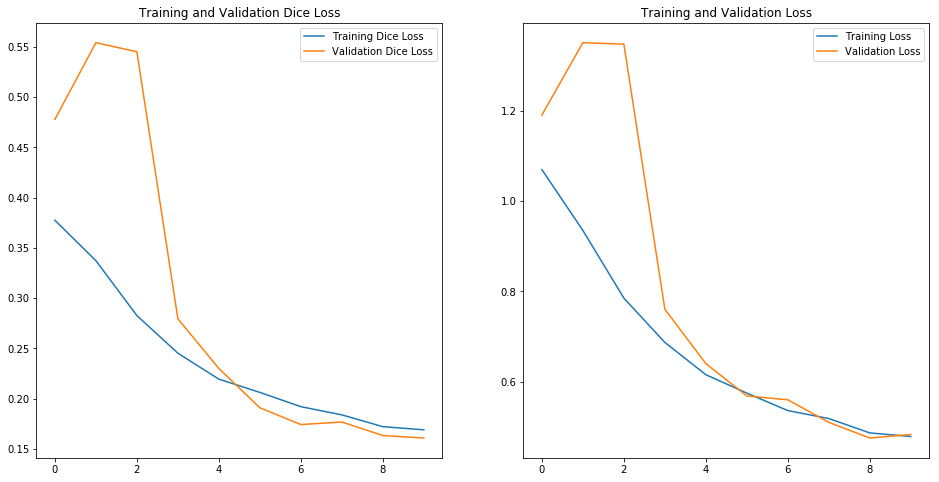

In [28]:
plot_fit_history(history)

### Модель с батч нормализацией, оптимизатор `adam`, добавлен параметр `decay=0.001` (убывание скорости обучения)(name - model_test_2)

In [21]:
model = segmentation_model.get_model(img_shape)
optimizer = optimizers.Adam(decay=0.001)
model.compile(optimizer=optimizer, loss=metrics.bce_dice_loss, metrics=[metrics.dice_loss])
save_model_path = 'saved_models/model_test_2'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/10
82/83 [============================>.] - ETA: 0s - loss: 0.8007 - dice_loss: 0.2956
Epoch 00001: val_dice_loss improved from inf to 0.30430, saving model to saved_models/model_test_2
83/83 [==============================] - 52s 627ms/step - loss: 0.7978 - dice_loss: 0.2945 - val_loss: 0.9027 - val_dice_loss: 0.3043
Epoch 2/10
82/83 [============================>.] - ETA: 0s - loss: 0.5744 - dice_loss: 0.2030
Epoch 00002: val_dice_loss improved from 0.30430 to 0.23907, saving model to saved_models/model_test_2
83/83 [==============================] - 25s 300ms/step - loss: 0.5747 - dice_loss: 0.2029 - val_loss: 0.7325 - val_dice_loss: 0.2391
Epoch 3/10
82/83 [============================>.] - ETA: 0s - loss: 0.4861 - dice_loss: 0.1680
Epoch 00003: val_dice_loss improved from 0.23907 to 0.21456, saving model to saved_models/model_test_2
83/83 [==============================] - 25s 306ms/step - loss: 0.4848 - dice_loss: 0.1675 - val_loss: 1.0446 - val_dice_loss: 0.2146
Epoch 4/

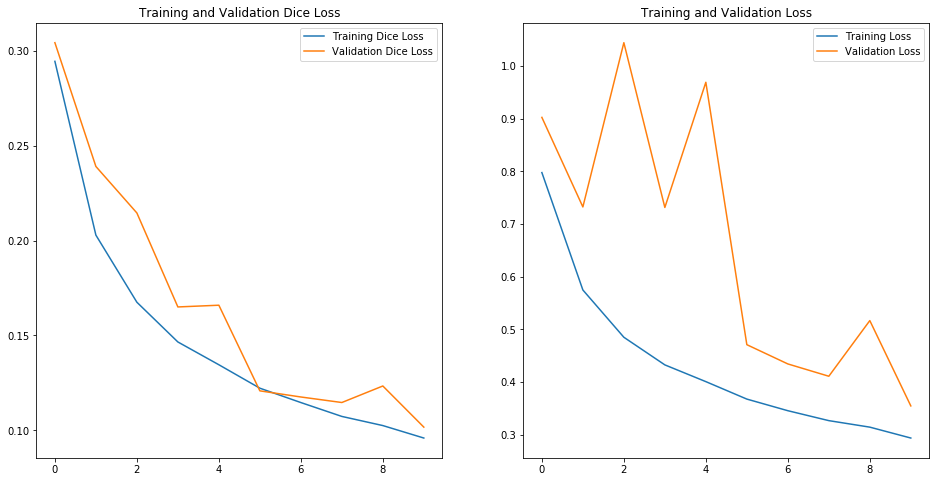

In [25]:
plot_fit_history(history)

In [26]:
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': metrics.bce_dice_loss,
                                                           'dice_loss': metrics.dice_loss})

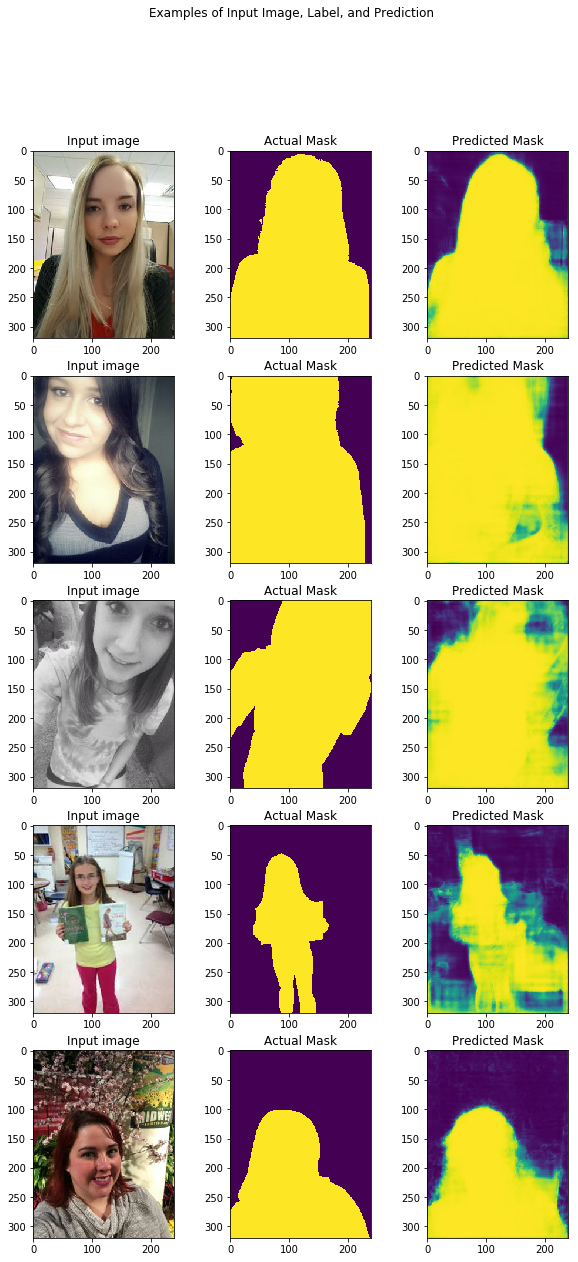

In [27]:
draw_examples(model, val_ds)

### Модель с батч нормализацией, оптимизатор `adam`, добавлен параметр `decay=0.001`, целевая функция `dice_loss`(name - model_test_2dice)

In [28]:
model = segmentation_model.get_model(img_shape)
optimizer = optimizers.Adam(decay=0.001)
model.compile(optimizer=optimizer, loss=metrics.dice_loss, metrics=[metrics.dice_loss])
save_model_path = 'saved_models/model_test_2dice'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/10
82/83 [============================>.] - ETA: 0s - loss: 0.2748 - dice_loss: 0.2748
Epoch 00001: val_dice_loss improved from inf to 0.43457, saving model to saved_models/model_test_2dice
83/83 [==============================] - 53s 634ms/step - loss: 0.2736 - dice_loss: 0.2736 - val_loss: 0.4346 - val_dice_loss: 0.4346
Epoch 2/10
82/83 [============================>.] - ETA: 0s - loss: 0.1816 - dice_loss: 0.1816
Epoch 00002: val_dice_loss improved from 0.43457 to 0.23396, saving model to saved_models/model_test_2dice
83/83 [==============================] - 25s 300ms/step - loss: 0.1816 - dice_loss: 0.1816 - val_loss: 0.2340 - val_dice_loss: 0.2340
Epoch 3/10
82/83 [============================>.] - ETA: 0s - loss: 0.1465 - dice_loss: 0.1465
Epoch 00003: val_dice_loss improved from 0.23396 to 0.16916, saving model to saved_models/model_test_2dice
83/83 [==============================] - 25s 298ms/step - loss: 0.1464 - dice_loss: 0.1464 - val_loss: 0.1692 - val_dice_loss: 0.1

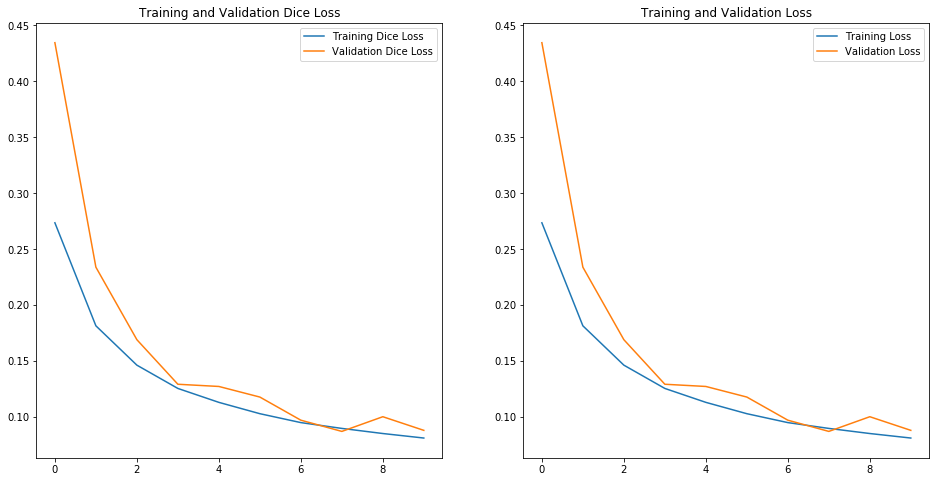

In [29]:
# Тут 'Dice Loss' = 'Loss'
plot_fit_history(history)

In [30]:
save_model_path = 'saved_models/model_test_2dice'
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': metrics.dice_loss,
                                                           'dice_loss': metrics.dice_loss})

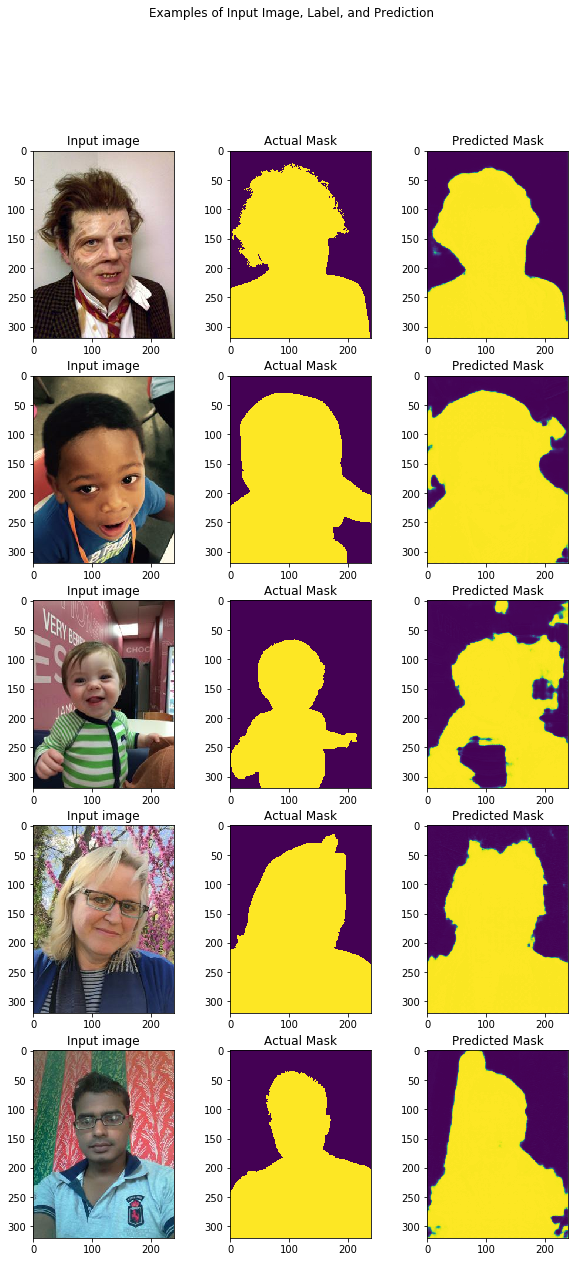

In [33]:
draw_examples(model, val_ds)

### Финальная модель с батч нормализацией, оптимизатор `adam`, добавлен параметр `decay=0.001`, целевая функция `bce_dice_loss`, 100 эпох обучения (name - model_final)

In [43]:
epochs = 100
model = segmentation_model.get_model(img_shape)
optimizer = optimizers.Adam(decay=0.001)
model.compile(optimizer=optimizer, loss=metrics.bce_dice_loss, metrics=[metrics.dice_loss])
save_model_path = 'saved_models/model_final'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/100
82/83 [============================>.] - ETA: 0s - loss: 0.8572 - dice_loss: 0.3189
Epoch 00001: val_dice_loss improved from inf to 0.31260, saving model to saved_models/model_final
83/83 [==============================] - 101s 1s/step - loss: 0.8562 - dice_loss: 0.3184 - val_loss: 1.1345 - val_dice_loss: 0.3126
Epoch 2/100
82/83 [============================>.] - ETA: 0s - loss: 0.6174 - dice_loss: 0.2263
Epoch 00002: val_dice_loss improved from 0.31260 to 0.23861, saving model to saved_models/model_final
83/83 [==============================] - 36s 437ms/step - loss: 0.6164 - dice_loss: 0.2259 - val_loss: 0.9601 - val_dice_loss: 0.2386
Epoch 3/100
82/83 [============================>.] - ETA: 0s - loss: 0.5104 - dice_loss: 0.1832
Epoch 00003: val_dice_loss improved from 0.23861 to 0.20553, saving model to saved_models/model_final
83/83 [==============================] - 36s 433ms/step - loss: 0.5109 - dice_loss: 0.1833 - val_loss: 0.9230 - val_dice_loss: 0.2055
Epoch 4/10

Epoch 27/100
82/83 [============================>.] - ETA: 0s - loss: 0.1869 - dice_loss: 0.0590
Epoch 00027: val_dice_loss did not improve from 0.07205
83/83 [==============================] - 34s 413ms/step - loss: 0.1877 - dice_loss: 0.0592 - val_loss: 0.2787 - val_dice_loss: 0.0770
Epoch 28/100
82/83 [============================>.] - ETA: 0s - loss: 0.1868 - dice_loss: 0.0600
Epoch 00028: val_dice_loss did not improve from 0.07205
83/83 [==============================] - 34s 411ms/step - loss: 0.1873 - dice_loss: 0.0601 - val_loss: 0.2699 - val_dice_loss: 0.0786
Epoch 29/100
82/83 [============================>.] - ETA: 0s - loss: 0.1854 - dice_loss: 0.0586
Epoch 00029: val_dice_loss did not improve from 0.07205
83/83 [==============================] - 34s 413ms/step - loss: 0.1862 - dice_loss: 0.0588 - val_loss: 0.2564 - val_dice_loss: 0.0768
Epoch 30/100
82/83 [============================>.] - ETA: 0s - loss: 0.1804 - dice_loss: 0.0577
Epoch 00030: val_dice_loss did not improve

83/83 [==============================] - 35s 427ms/step - loss: 0.1289 - dice_loss: 0.0404 - val_loss: 0.2331 - val_dice_loss: 0.0614
Epoch 55/100
82/83 [============================>.] - ETA: 0s - loss: 0.1337 - dice_loss: 0.0416
Epoch 00055: val_dice_loss improved from 0.06142 to 0.06099, saving model to saved_models/model_final
83/83 [==============================] - 36s 428ms/step - loss: 0.1336 - dice_loss: 0.0416 - val_loss: 0.2292 - val_dice_loss: 0.0610
Epoch 56/100
82/83 [============================>.] - ETA: 0s - loss: 0.1286 - dice_loss: 0.0403
Epoch 00056: val_dice_loss did not improve from 0.06099
83/83 [==============================] - 34s 412ms/step - loss: 0.1287 - dice_loss: 0.0403 - val_loss: 0.2609 - val_dice_loss: 0.0642
Epoch 57/100
82/83 [============================>.] - ETA: 0s - loss: 0.1310 - dice_loss: 0.0411
Epoch 00057: val_dice_loss improved from 0.06099 to 0.06043, saving model to saved_models/model_final
83/83 [==============================] - 36s 43

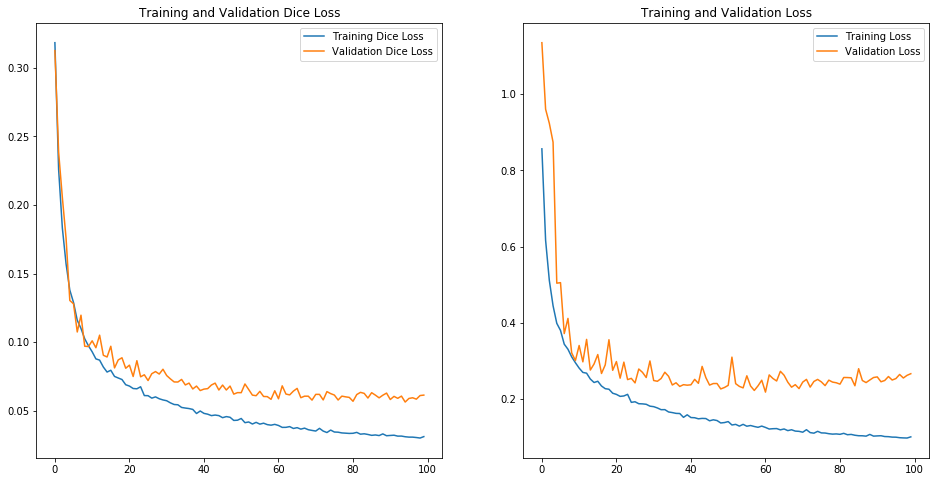

In [44]:
plot_fit_history(history)

In [11]:
save_model_path = 'saved_models/model_final'
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': metrics.bce_dice_loss,
                                                           'dice_loss': metrics.dice_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


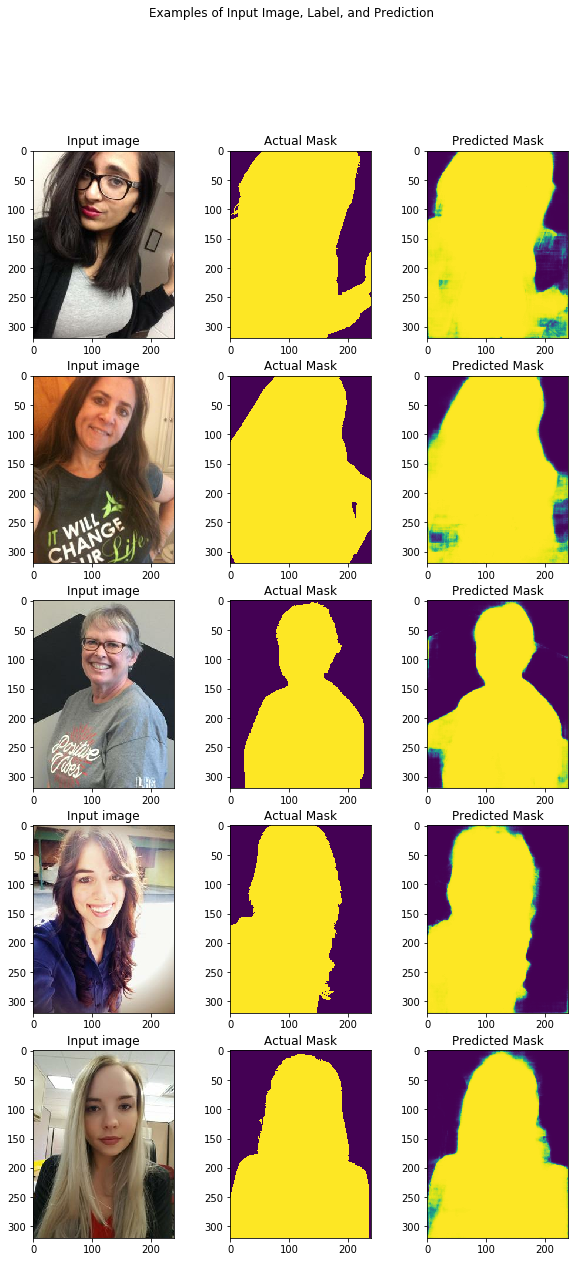

In [14]:
draw_examples(model, val_ds)

### Генерация итоговых (проверочных) файлов на основе финальной модели.

In [3]:
save_model_path = 'saved_models/model_final'
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': metrics.bce_dice_loss,
                                                           'dice_loss': metrics.dice_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
x_path = 'data/data/test/'
x_test_filenames, _ = dataset_utils.get_images_filenames(x_path, y_path=None)

In [36]:
test_samples = np.array([np.array(Image.open(f_path)) for f_path in x_test_filenames])
test_samples = test_samples * (1 / 255.)
predicted_masks = model.predict(test_samples, batch_size=16)

In [37]:
predicted_masks = np.reshape(predicted_masks, predicted_masks.shape[:-1])

In [38]:
predicted_masks = predicted_masks * 255.0

In [39]:
predicted_masks = predicted_masks.astype(np.uint8)

In [40]:
# "255 / 2" по идее это параметр можно было подобрать по валидационной выборке.
predicted_masks[predicted_masks > 255 / 2 ] = 255
predicted_masks[predicted_masks < 255 / 2] = 0

In [41]:
paths_to_imgs = sorted([i.replace('\\', '/') for i in glob("data/data/test/*")])
_ = get_html(paths_to_imgs, predicted_masks, path_to_save="results/example")

### Генерация valid.csv (которую я проморгал)

In [5]:
x_path = 'data/data/valid/'
x_valid_filenames, _ = dataset_utils.get_images_filenames(x_path, y_path=None)

In [6]:
valid_samples = np.array([np.array(Image.open(f_path)) for f_path in x_valid_filenames])
valid_samples = valid_samples * (1 / 255.)
predicted_masks = model.predict(valid_samples, batch_size=16)

In [7]:
predicted_masks = np.reshape(predicted_masks, predicted_masks.shape[:-1])

In [8]:
predicted_masks = predicted_masks * 255.0

In [9]:
predicted_masks = predicted_masks.astype(np.uint8)

In [10]:
predicted_masks[predicted_masks > 255 / 2 ] = 255
predicted_masks[predicted_masks < 255 / 2] = 0

In [11]:
data_to_csv = []
for name, mask in zip(x_valid_filenames, predicted_masks):
    id_image = name.split('/')[-1].split('.')[0]
    encoded_mask = encode_rle(mask)
    data_to_csv.append([id_image, encoded_mask])
    decoded_mask = decode_rle(encoded_mask)

In [12]:
pd_data_to_csv = pd.DataFrame(data_to_csv, columns=['id', 'rle_mask'])

In [13]:
pd_data_to_csv.head()

,id,rle_mask
0,1315,70 119 309 121 547 123 782 130 1020 1 1022 130...
1,1316,8551 1 8785 3 8790 5 8799 1 9017 19 9037 5 925...
2,1317,9467 8 9704 18 9938 33 10175 43 10415 47 10652...
3,1318,8089 1 8328 3 8566 12 8623 1 8804 15 8863 1 90...
4,1319,22656 6 22663 1 22665 3 22894 14 23130 3 23134...


In [16]:
csv_path = 'data/pred_valid.csv'
pd_data_to_csv.to_csv(csv_path, index=False)